In [3]:
from vampires_calibration.csv_tools import read_csv,read_csv_physical_model_all_bins,model_data
from vampires_calibration.fitting import model
from vampires_calibration.utils import *
from vampires_calibration.constants import wavelength_bins
from pyMuellerMat.physical_models.charis_physical_models import *
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
wavelength_bins

array([1159.5614, 1199.6971, 1241.2219, 1284.184 , 1328.6331, 1374.6208,
       1422.2002, 1471.4264, 1522.3565, 1575.0495, 1629.5663, 1685.9701,
       1744.3261, 1804.7021, 1867.1678, 1931.7956, 1998.6603, 2067.8395,
       2139.4131, 2213.4641, 2290.0781, 2369.3441])

In [25]:
# calculate s rel 

interleaved_values_internal, interleaved_stds_internal, config_list_internal = read_csv_physical_model_all_bins('/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/CHARIS/datacsvs/csvs_nopickoff')
dds_internal = np.array(process_dataset(interleaved_values_internal)[::2])
dds_internal.shape

(704,)

In [31]:
# get naive fit retardances (where offsets were fit to)

df = model_data('../system_dictionaries/scipy_minimize_just_rets',offsets=False )
hwp_phi_list = df['hwp_phi'].values

df_eps = model_data('../system_dictionaries/diattenuations_cal_polarizer' )
df_wol = model_data('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/imr_naive_wollaston_trans')
imr_phi_list = df_wol['image_rotator_phi'].values
# repeat each retardance for each measurement in csv
hwp_phi_list = np.array([i for i in hwp_phi_list for _ in range(64)])
imr_phi_list = np.array([i for i in imr_phi_list for _ in range(64)])
#lp_epsilon_list = np.array([i for i in df_wol['lp_epsilon'].values for _ in range(64)])
wol_eta_list = np.array([i for i in df_wol['wollaston_eta'].values for _ in range(64)])
bin_list = np.array([i for i in wavelength_bins for _ in range(64)])
# df_wol

df_elip = model_data('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/elliptical_imr')
imr_phi_h_list = np.array([i for i in df_elip['image_rotator_phi_h'].values for _ in range(64)])
imr_phi_45_list = np.array([i for i in df_elip['image_rotator_phi_45'].values for _ in range(64)])
imr_phi_r_list = np.array([i for i in df_elip['image_rotator_phi_r'].values for _ in range(64)])


In [32]:
modeled_internal = np.array([])
for dd in range(len(config_list_internal)):

    # get model ready
    #hwp_phi = hwp_phi_list[dd]
    #imr_phi = imr_phi_list[dd]
    offset_imr = -0.13959
    offset_hwp = -1.59338
    offset_cal = -0.11835
    lp_eps = 1
    wavelength_bin = bin_list[dd]
    hwp_phi = HWP_retardance(wavelength_bin, 1.63398,1.27711)[0]
    imr_phi = IMR_retardance(wavelength_bin ,259.11814)[0]
    wol_eta = wol_eta_list[dd]
    imr_phi = imr_phi_list[dd]
    phi_h = imr_phi_h_list[dd]
    phi_45 = imr_phi_45_list[dd]
    phi_r = imr_phi_r_list[dd]

    # define system dictionary
    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o','eta':wol_eta}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "elliptical_retarder_function",
                    "properties" : {"phi_h": phi_h, "phi_45": phi_45, "phi_r": phi_r, "theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },

                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "diattenuator_retarder_function",
                    "properties": {"epsilon": lp_eps, "delta_theta": offset_cal},
                    "tag": "internal",
                }},
        }
    
    # define p0 dict (it doesnt do anything its just necessary for model function to work)

    p0_dict = {
    "lp" : 
        {"epsilon":lp_eps}
 }

    # generate system mueller matrix    
    system_mm = generate_system_mueller_matrix(system_dict)
    p, pkeys = parse_configuration(p0_dict)
    
    # generate model
    configlist = [config_list_internal[dd]]
    modeled_dd = model(p, pkeys, system_mm, configlist)
    modeled_internal = np.concatenate((modeled_internal, modeled_dd))

modeled_internal = process_model(modeled_internal)[::2]

print(modeled_internal)

Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelengt

In [78]:
modeled_internal = np.array([])
for dd in range(len(config_list_internal)):

    # get model ready
    hwp_phi = hwp_phi_list[dd]
    imr_phi = imr_phi_list[dd]
    offset_imr = 0
    offset_hwp = 0
    offset_cal = 0
    lp_eps = 1
    wavelength_bin = bin_list[dd]
    hwp_phi = HWP_retardance(wavelength_bin, 1.589,1.24231)[0]
    #imr_phi = IMR_retardance(wavelength_bin ,259.11814)[0]
    wol_eta = wol_eta_list[dd]

    # define system dictionary
    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o','eta':wol_eta}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": imr_phi, "theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "lp_rot": {
                    "type": "rotator_function",
                    "properties": {"theta": offset_cal},
                    "tag": "internal",
                },
                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "diattenuator_retarder_function",
                    "properties": {"epsilon": lp_eps},
                    "tag": "internal",
                }},
        }
    
    # define p0 dict (it doesnt do anything its just necessary for model function to work)

    p0_dict = {
    "lp" : 
        {"epsilon":lp_eps}
}

    # generate system mueller matrix    
    system_mm = generate_system_mueller_matrix(system_dict)
    p, pkeys = parse_configuration(p0_dict)
    
    # generate model
    configlist = [config_list_internal[dd]]
    modeled_dd = model(p, pkeys, system_mm, configlist)
    modeled_internal = np.concatenate((modeled_internal, modeled_dd))

modeled_internal = process_model(modeled_internal)[::2]

print(modeled_internal)

Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelengt

In [33]:
# calculate s res
from vampires_calibration.plotting import plot_data_and_model
# generate s
s_res_by_wavelength = []
for bin in range(22):
    # mask per bin
    bin_mask = []
    for dict in config_list_internal[::2]:
        if dict['hwp']['wavelength'] == wavelength_bins[bin]:
            bin_mask.append(True)
        else:
            bin_mask.append(False)

    # apply mask
    double_diffs_bin = dds_internal[bin_mask]
    modeled_double_differences_bin = modeled_internal[bin_mask]
    residualss = (double_diffs_bin*100-modeled_double_differences_bin*100)
    print(residualss)
    # calculate s_res as in appendix E of SPHERE cal paper
    residuals = (double_diffs_bin*100-modeled_double_differences_bin*100)
    s_res = np.sqrt(np.sum(residuals**2)/(len(dds_internal[bin_mask])))
    s_res_by_wavelength.append(s_res)

[ 3.44320784  3.76457075  2.16425278 -0.72125123  1.99173733  2.40247743
  2.27896808  0.46413121  0.93980908  1.18575865  1.39068186  0.62126169
  0.60109806  0.25975297  0.76388886  0.47175683 -0.05161465  0.16424874
  0.13009226  0.64733584 -1.32685153 -0.33006995  0.48706373  1.16870035
 -2.35574417 -0.87836917  0.49945828  2.12133881 -3.59447391 -1.32131531
  0.92528904  2.75359495]
[ 1.95297687  2.17707986  1.42644251 -0.41514611  1.93376831  0.97375351
  0.80570436 -0.2525509   1.52094741  0.65545619 -0.24683951 -0.29073121
  0.49861175  0.39451428 -0.58664182 -0.74700322  0.12014182 -0.11128383
 -0.28476447 -1.06925653  0.12672884 -0.02328764  0.24915153 -0.28972371
 -1.00588219  0.25873883  0.48188823  1.01477882 -2.22773893 -0.42085139
  0.54787592  1.1437555 ]
[ 0.87322677  1.05354783  0.95014566  0.12842756  0.91676648  0.4548971
  0.45854925 -0.04650491  1.03134284  0.15290622 -0.13646017 -0.27730151
  0.74039918  0.17328078 -0.49738089 -0.57853128  0.48314359  0.05256367


Text(0, 0.5, 's_rel (%)')

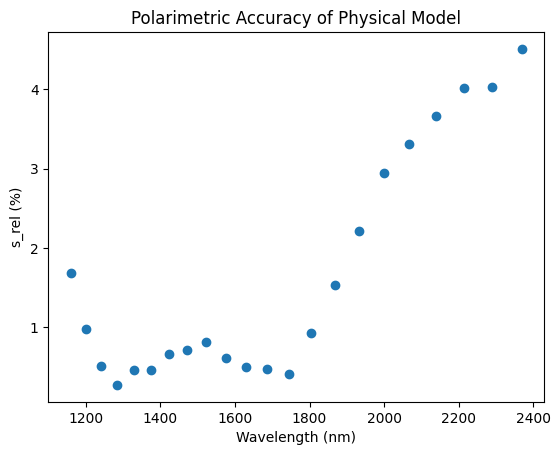

In [34]:
plt.scatter(wavelength_bins, s_res_by_wavelength)
plt.title('Polarimetric Accuracy of Physical Model')
plt.xlabel('Wavelength (nm)')
plt.ylabel ('s_rel (%)')

In [13]:
interleaved_values_unpol,interleaved_stds_unpol, config_list_unpol = read_csv_physical_model_all_bins('../datacsvs/onsky_csvs/unpol_standards',m3=True)
dds_unpol = np.array(process_dataset(interleaved_values_unpol)[::2])

In [14]:
bin_list_unpol = np.array([i for i in wavelength_bins for _ in range(212)])

In [15]:
# calculate s abs

modeled_unpol = np.array([])
for dd in range(len(config_list_unpol)):

    # get model ready
    #hwp_phi = hwp_phi_list[dd]
    #imr_phi = imr_phi_list[dd]
    offset_imr = -0.13959
    offset_hwp = -1.59338
    offset_cal = -0.11835
    #lp_eps = lp_epsilon_list[dd]
    wavelength_bin = bin_list_unpol[dd]
    hwp_phi = HWP_retardance(wavelength_bin, 1.63398,1.27711)[0]
    imr_phi = IMR_retardance(wavelength_bin ,259.11814)[0]
    m1, b1, m2, b2 = (2.19663,13.12958,1.74416,14.05076)

    # define system dictionary
    system_dict_unpol = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o'}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": imr_phi, "theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "altitude_rot" : {
                    "type" : "rotator_function",
                    "properties" : {"pa":77},
                    "tag":"internal",
                },
                "M3" : {
                    "type" : "SUBARU_M3_function",
                    "properties" : {"wavelength": wavelength_bin, "m1":m1, "b1":b1, "m2":m2, "b2":b2},
                    "tag": "internal",
                },
                "parang_rot" : {
                    "type" : "rotator_function",
                    "properties" : {"pa":39},
                    "tag":"internal",
                },
            }}
                
        
    
    # define p0 dict (it doesnt do anything its just necessary for model function to work)
    p0_dict = {
                "M3" : 
                    {"m1":m1}
            }

    # generate system mueller matrix    
    system_mm = generate_system_mueller_matrix(system_dict_unpol)
    p, pkeys = parse_configuration(p0_dict)
    
    # generate model
    configlist = [config_list_unpol[dd]]
    modeled_dd = model(p, pkeys, system_mm, configlist)
    modeled_unpol = np.concatenate((modeled_unpol, modeled_dd))

modeled_unpol = process_model(modeled_unpol)[::2]

print(modeled_unpol)

Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelengt

In [24]:
# calculate s res

# generate s
s_res_by_wavelength_unpol = []
for bin in range(22):
    # mask per bin
    bin_mask = []
    for dict in config_list_unpol[::2]:
        if dict['hwp']['wavelength'] == wavelength_bins[bin]:
            bin_mask.append(True)
        else:
            bin_mask.append(False)

    # apply mask
    double_diffs_bin = dds_unpol[bin_mask]
    modeled_double_differences_bin = modeled_unpol[bin_mask]
    # calculate s_res as in appendix E of SPHERE cal paper
    residuals = (double_diffs_bin*100-modeled_double_differences_bin*100)
    s_res = np.sqrt(np.sum(residuals**2)/(len(dds_unpol[bin_mask]-8)))
    s_res_by_wavelength_unpol.append(s_res)

NameError: name 'config_list_unpol' is not defined

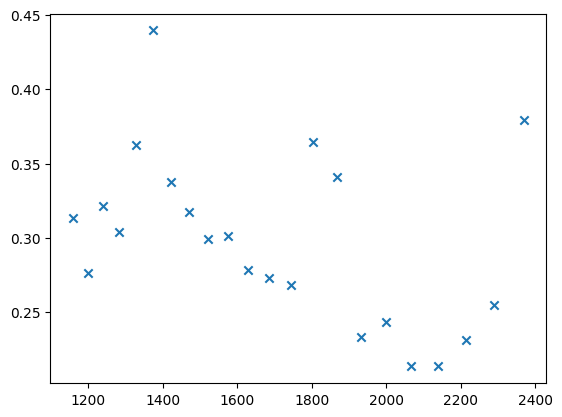

In [17]:
plt.scatter(wavelength_bins, s_res_by_wavelength_unpol, marker='x')

Wavelength bin 1159.5614 nm: s_rel = 1.7528242689315567 %


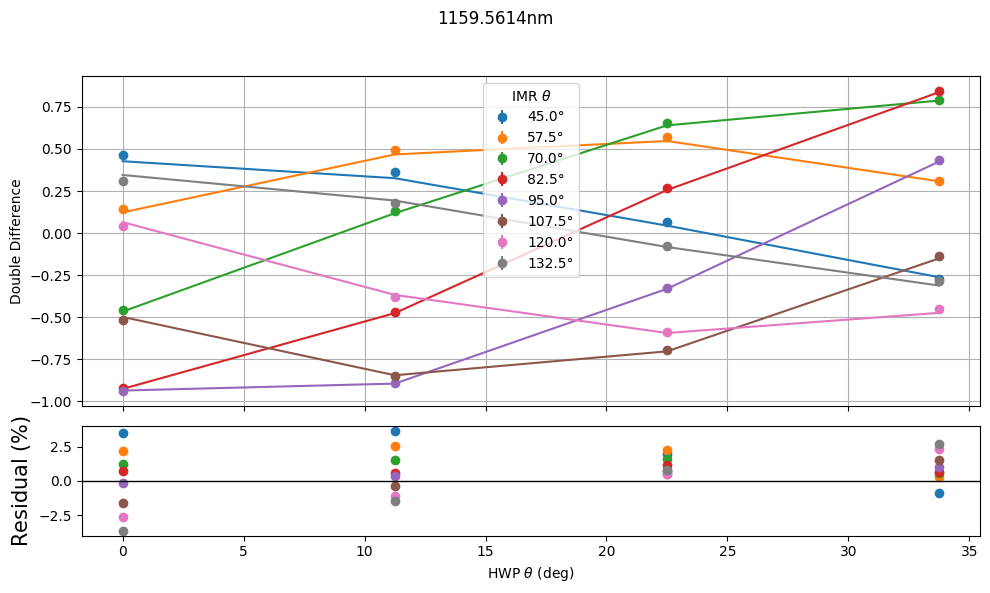

Wavelength bin 1199.6971 nm: s_rel = 1.0071704306391307 %


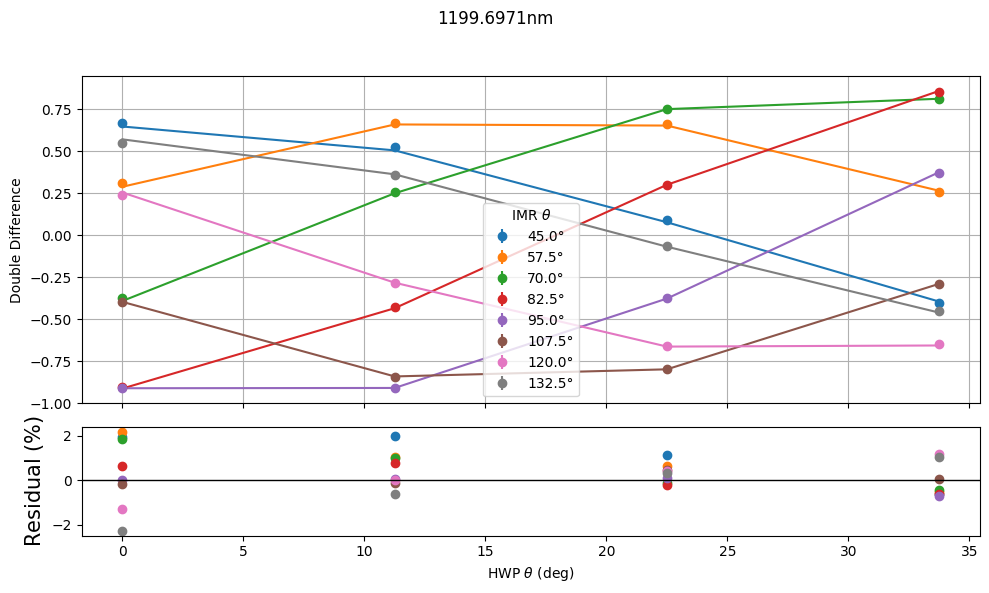

Wavelength bin 1241.2219 nm: s_rel = 0.5251032363815139 %


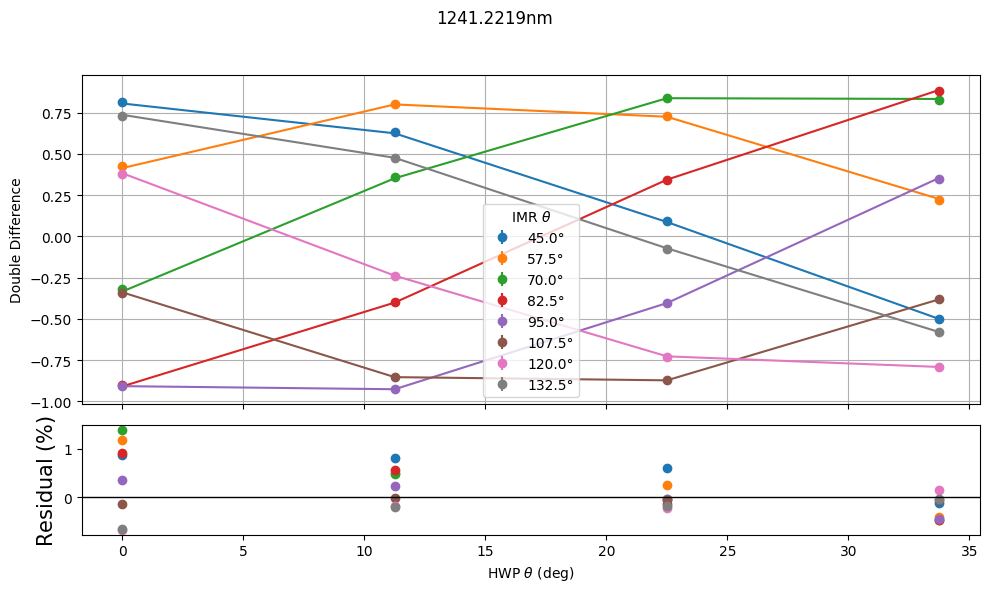

Wavelength bin 1284.184 nm: s_rel = 0.3331134563892018 %


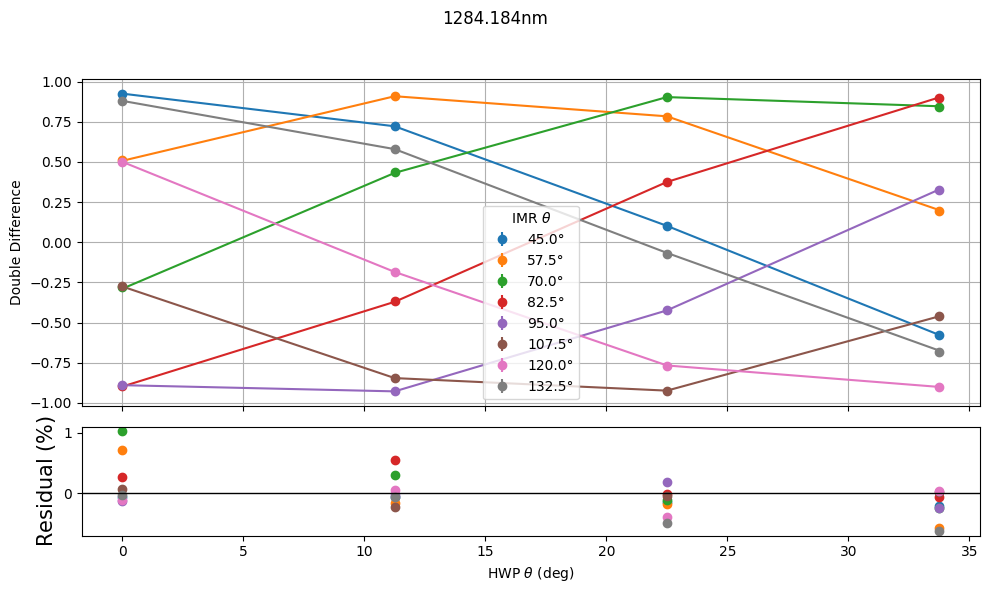

Wavelength bin 1328.6331 nm: s_rel = 0.5418755238066709 %


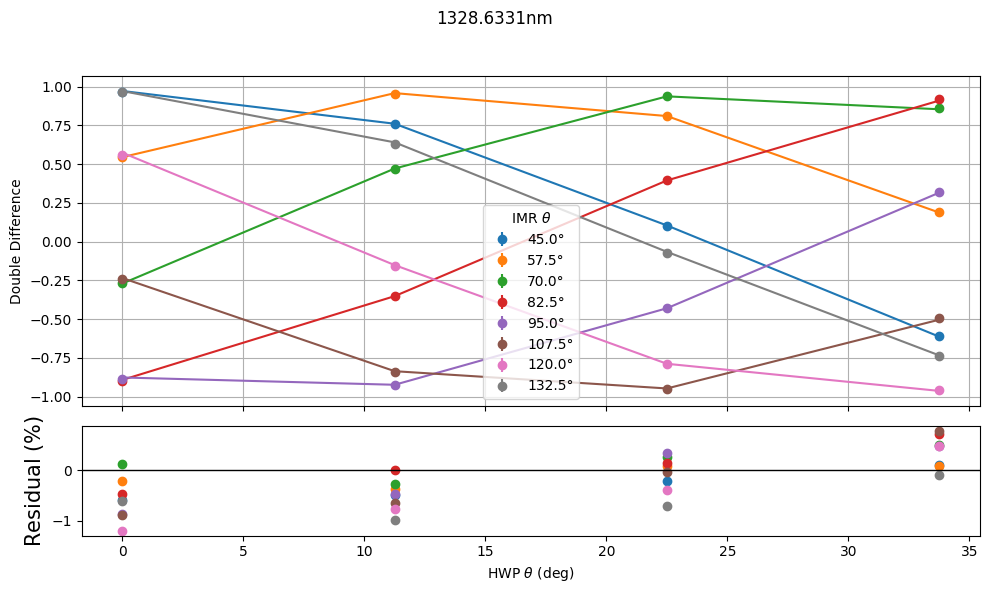

Wavelength bin 1374.6208 nm: s_rel = 0.6268940758758443 %


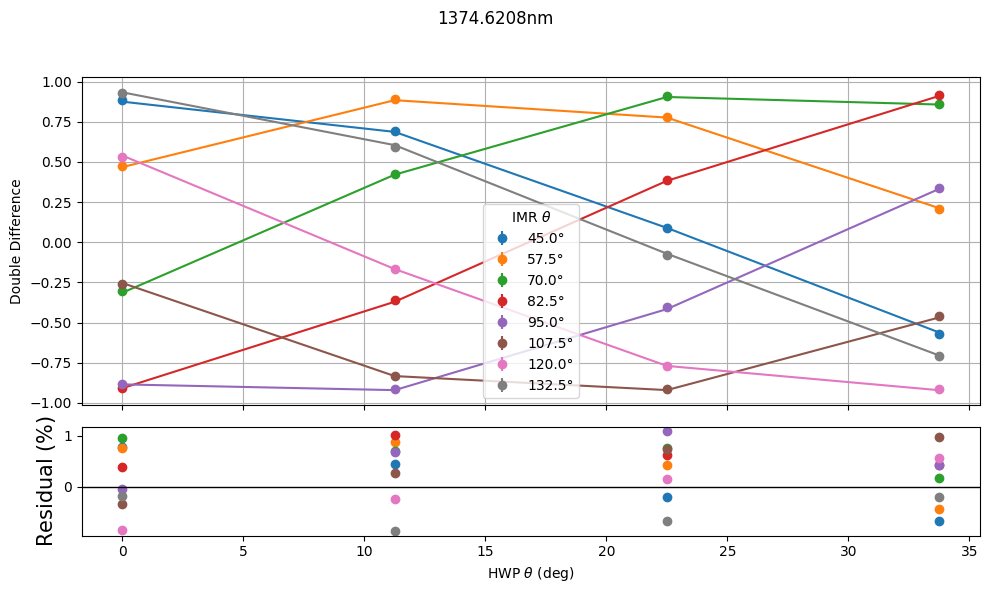

Wavelength bin 1422.2002 nm: s_rel = 0.7919803144972429 %


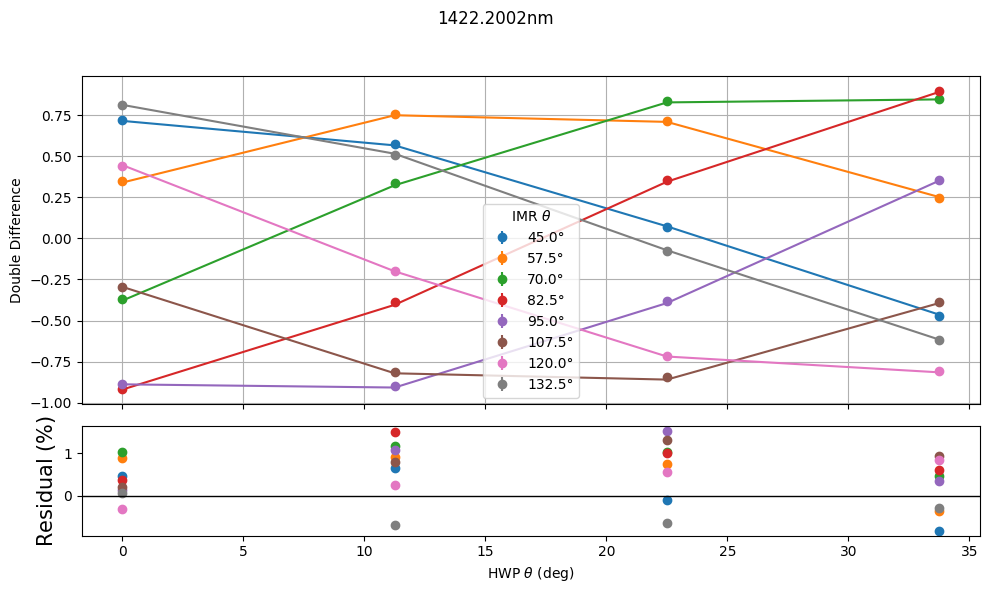

Wavelength bin 1471.4264 nm: s_rel = 0.8704457940958363 %


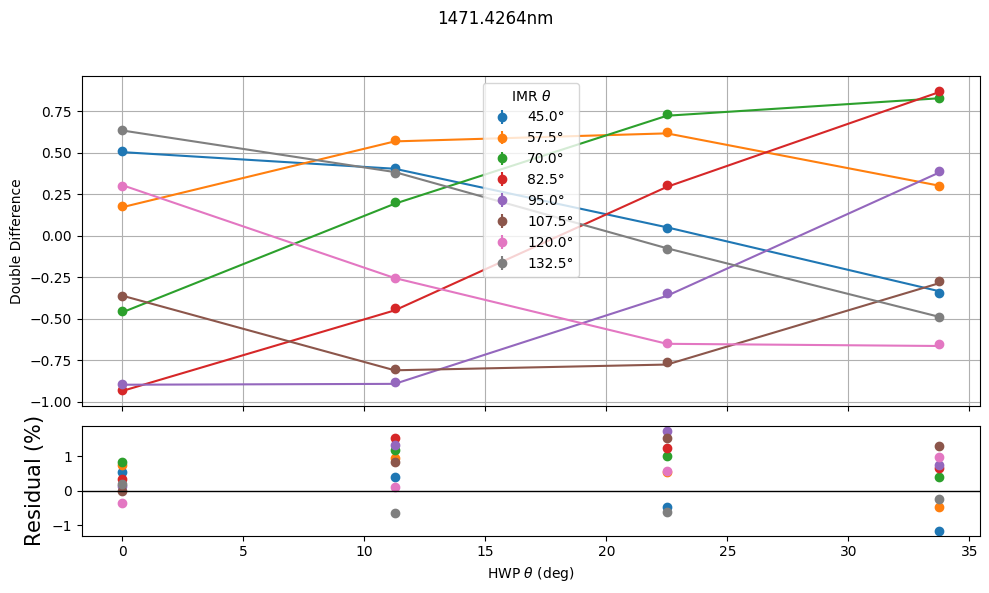

Wavelength bin 1522.3565 nm: s_rel = 0.9883826253867953 %


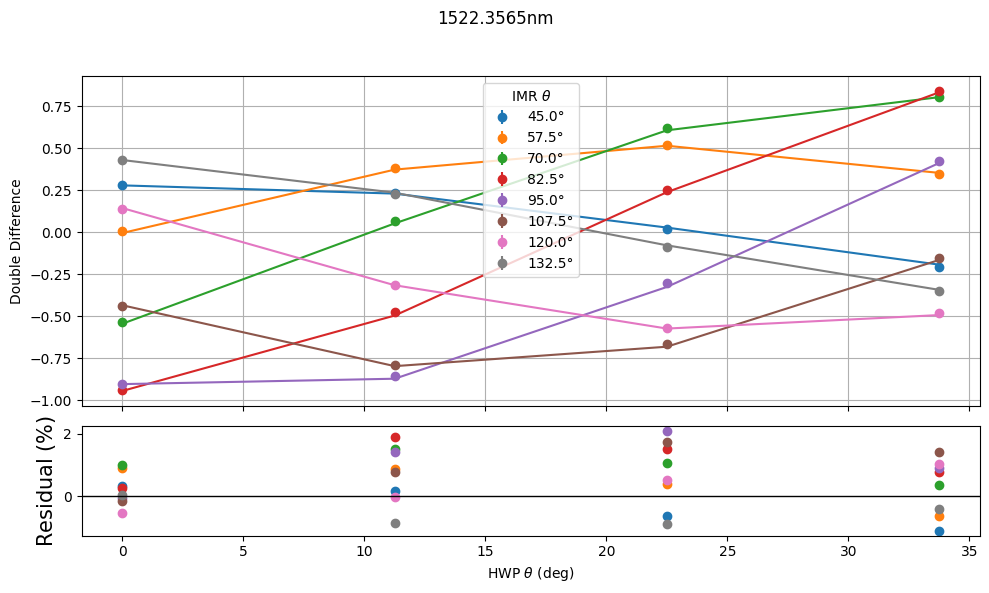

Wavelength bin 1575.0495 nm: s_rel = 0.7760419263583365 %


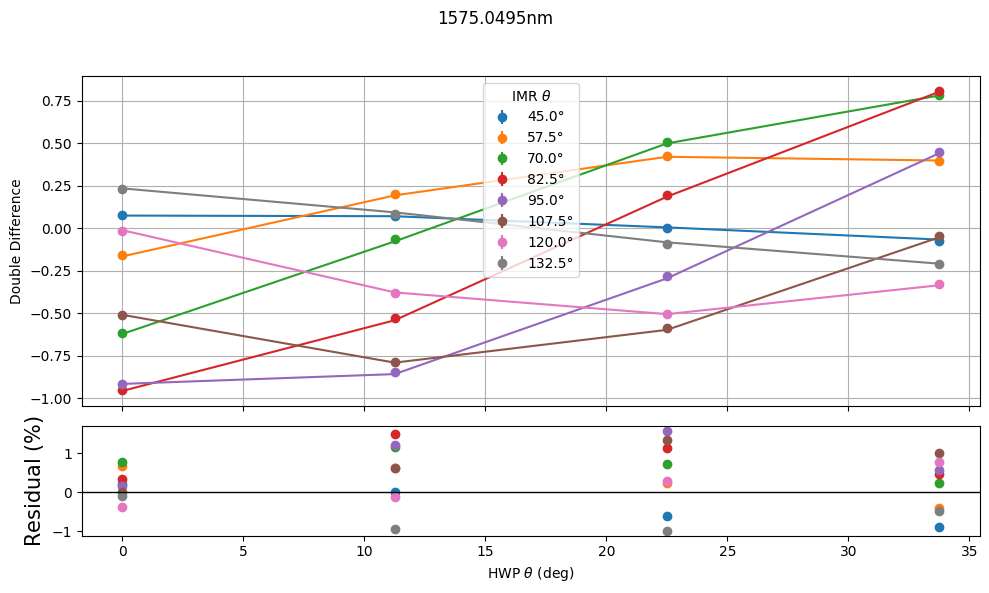

Wavelength bin 1629.5663 nm: s_rel = 0.5990012190401296 %


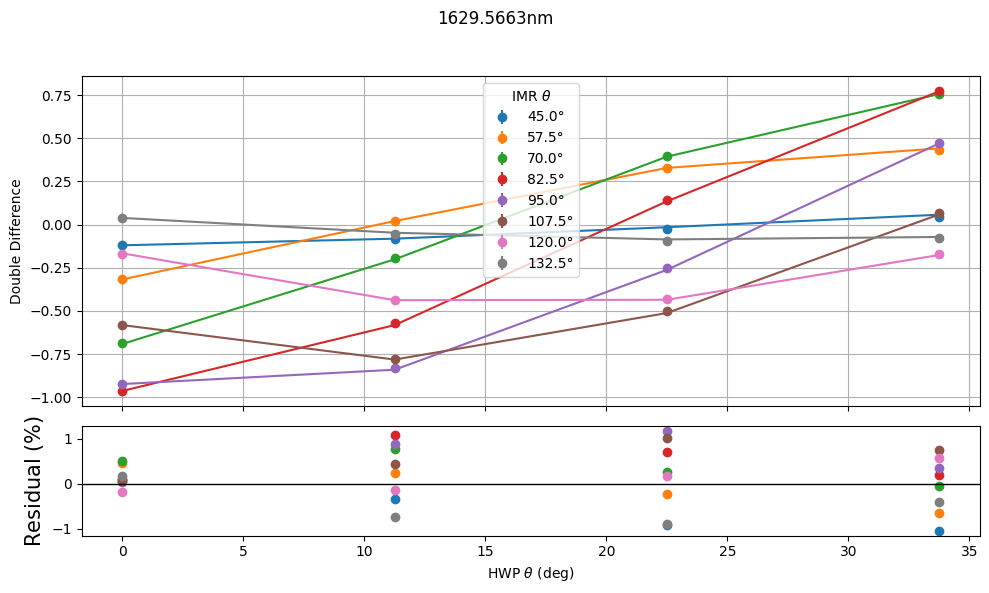

Wavelength bin 1685.9701 nm: s_rel = 0.5332650703200901 %


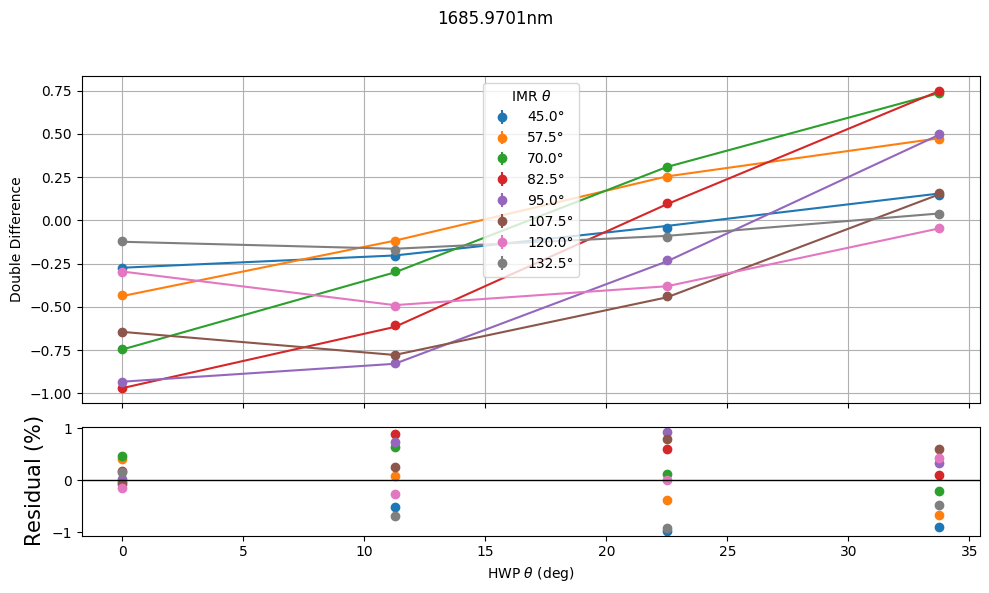

Wavelength bin 1744.3261 nm: s_rel = 0.47809186143924887 %


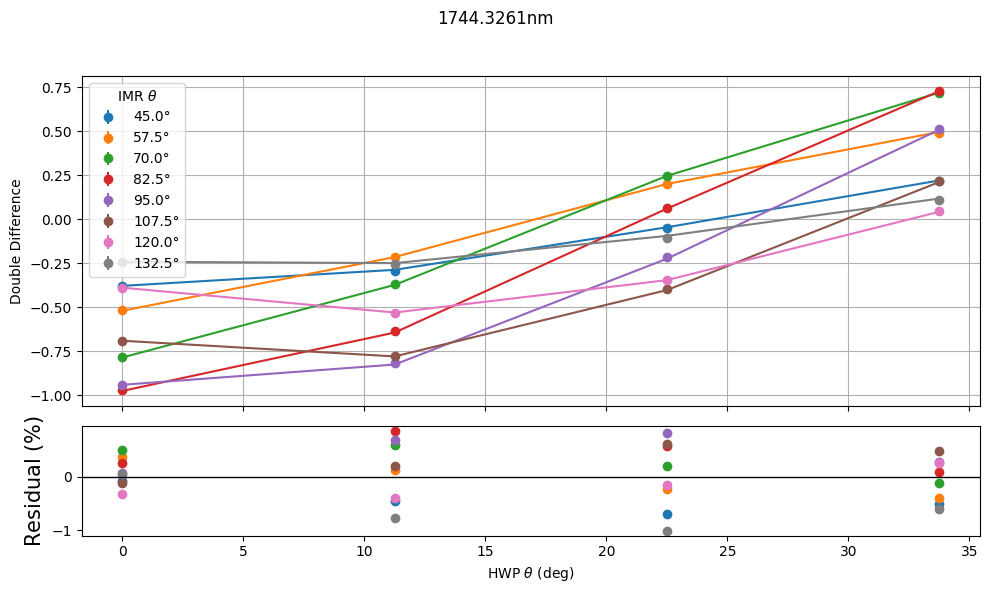

Wavelength bin 1804.7021 nm: s_rel = 0.3624520783175964 %


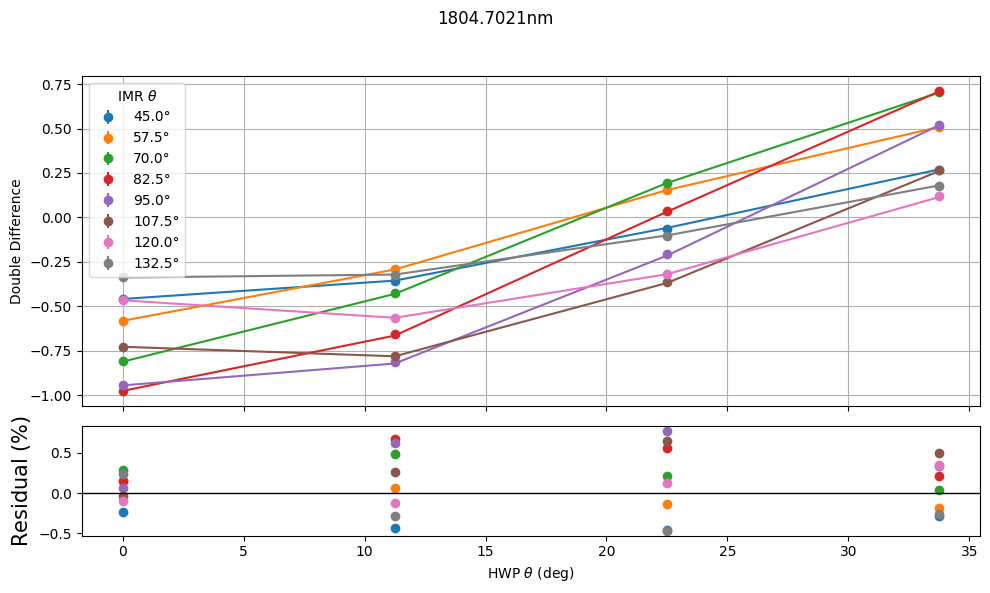

Wavelength bin 1867.1678 nm: s_rel = 0.3425413870376043 %


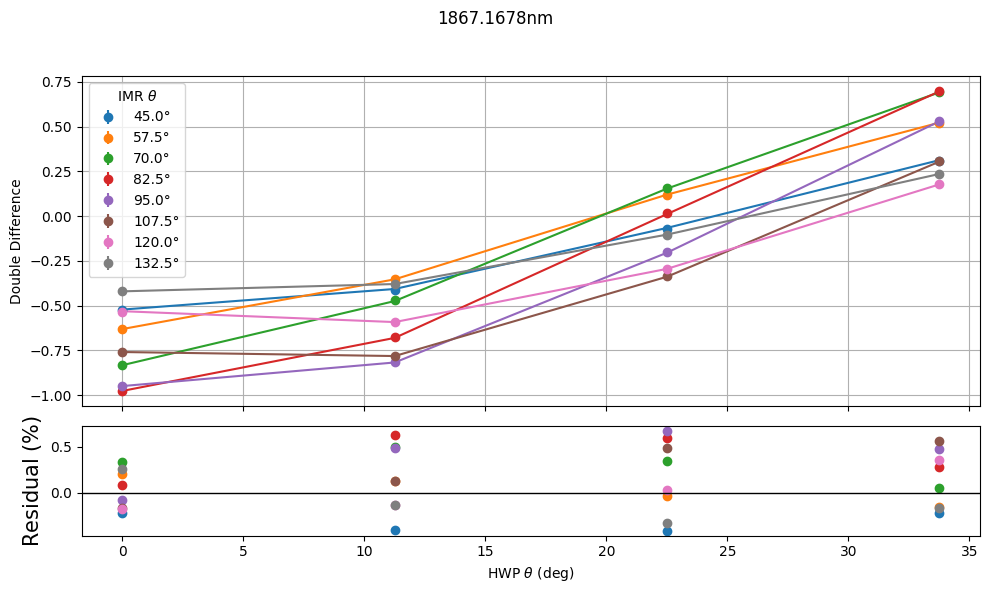

Wavelength bin 1931.7956 nm: s_rel = 0.27616940650172067 %


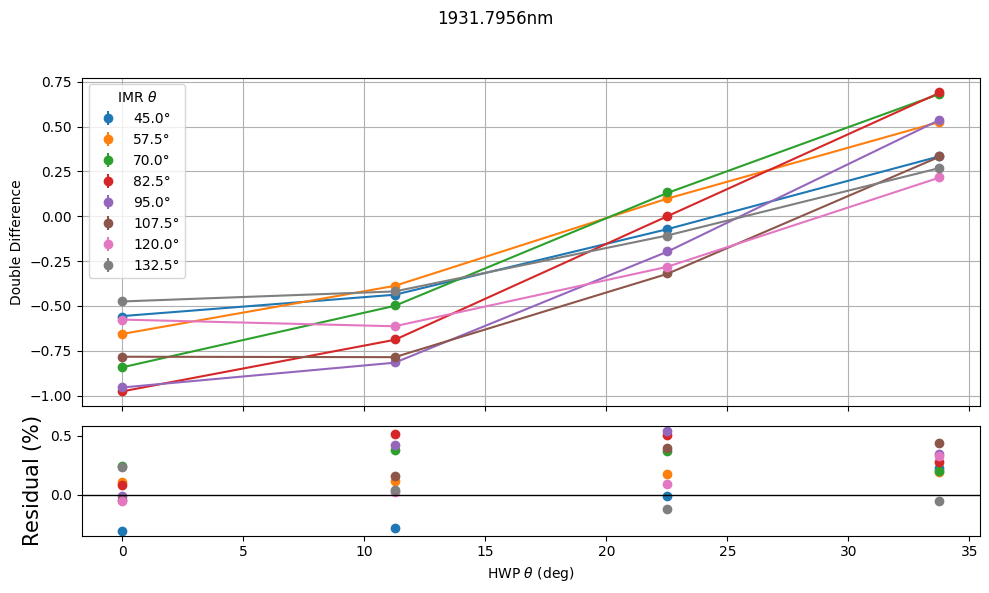

Wavelength bin 1998.6603 nm: s_rel = 0.3126293966252295 %


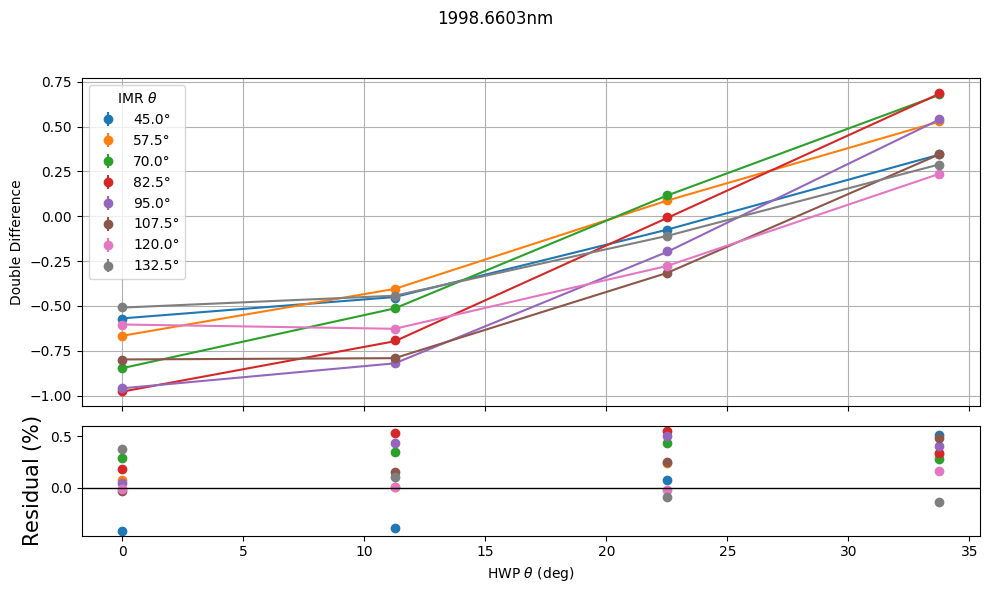

Wavelength bin 2067.8395 nm: s_rel = 0.3137692028689907 %


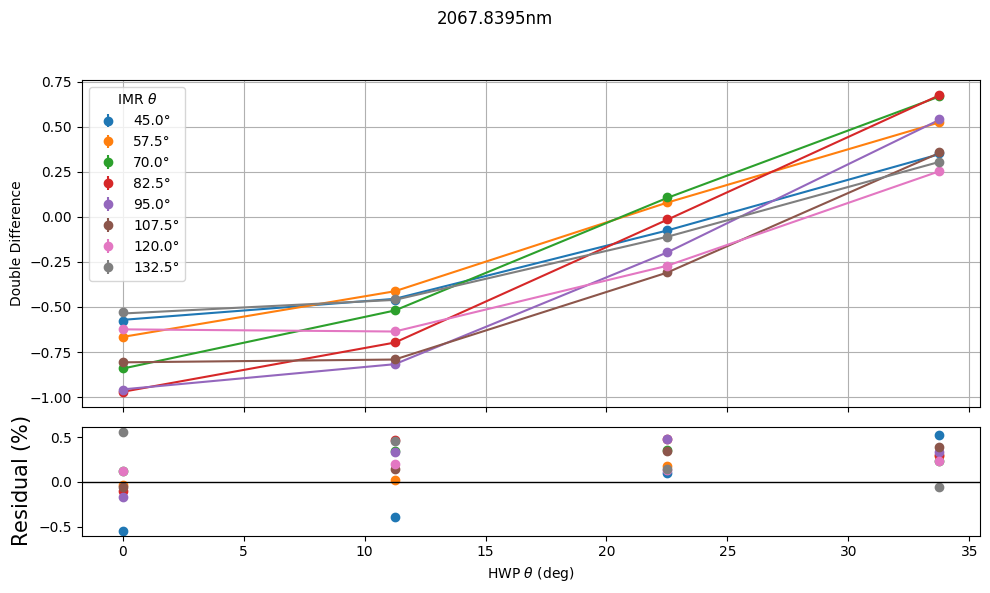

Wavelength bin 2139.4131 nm: s_rel = 0.33574298856855256 %


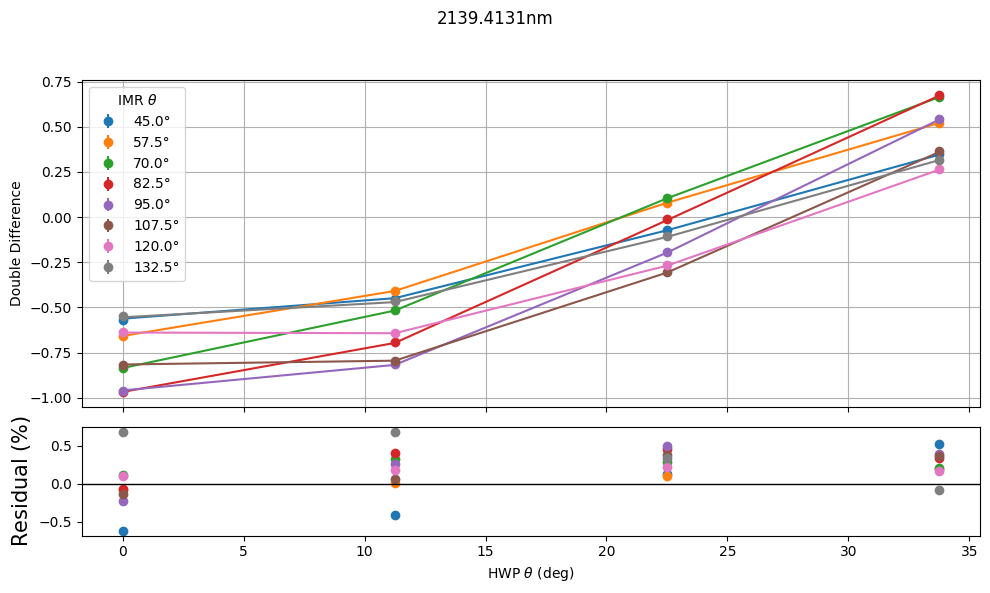

Wavelength bin 2213.4641 nm: s_rel = 0.42471020349187544 %


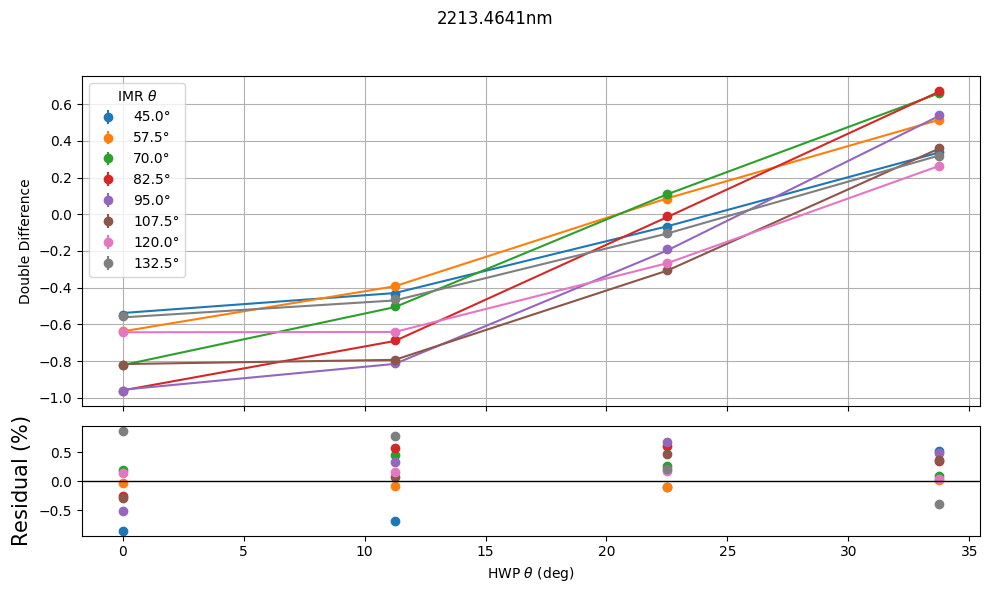

Wavelength bin 2290.0781 nm: s_rel = 0.34875701429524836 %


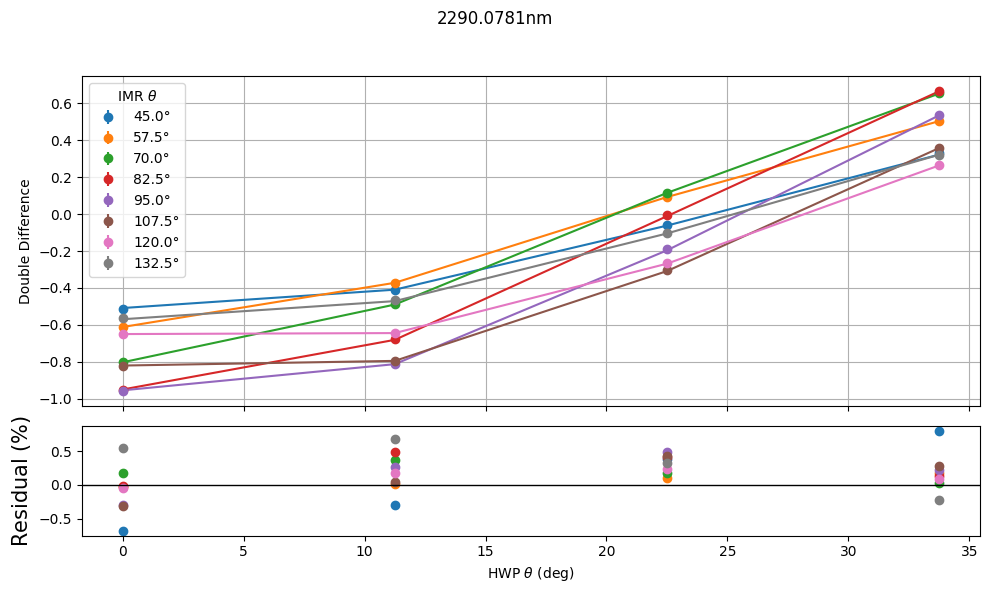

Wavelength bin 2369.3441 nm: s_rel = 1.4975894248832893 %


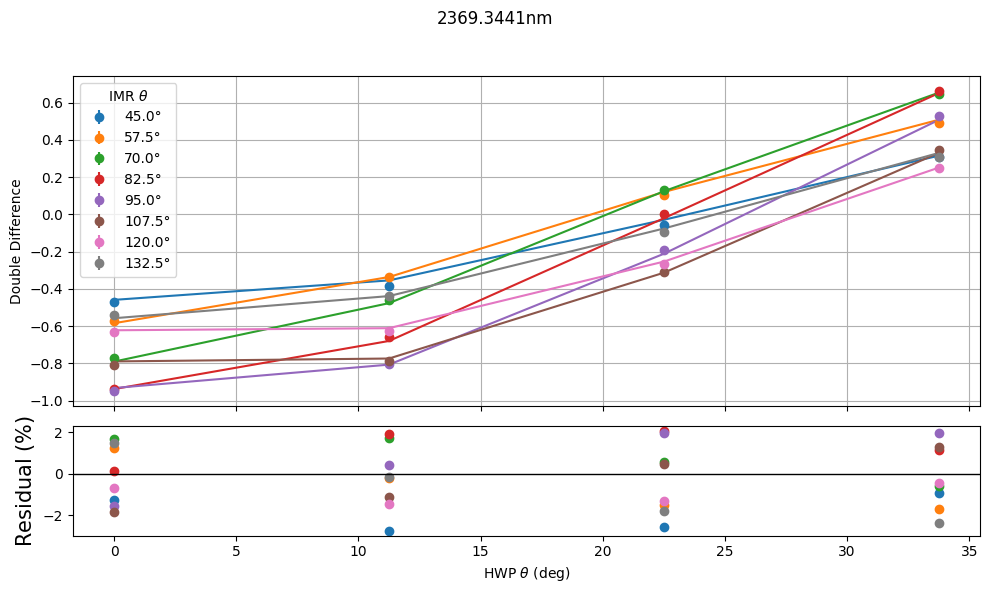

In [9]:
# recalculate by bin
from vampires_calibration.plotting import plot_data_and_model
sres_list = []
for bin in range(22):

    # read in data
    interleaved_val,interleaved_std, configs = read_csv(f'../datacsvs/csvs_nopickoff/charis_cube_info_bin{bin}_no_pickoff.csv')
    dds = np.array(process_dataset(interleaved_val)[::2])

    # get model ready
    df_elip = model_data('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/elliptical_imr')
    imr_phi_h = df_elip['image_rotator_phi_h'].values[bin]
    imr_phi_45 = df_elip['image_rotator_phi_45'].values[bin]
    imr_phi_r = df_elip['image_rotator_phi_r'].values[bin]
    df_wol = model_data('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/imr_naive_wollaston_trans')
    imr_phi_wol = df_wol['image_rotator_phi'].values[bin]
    wol_eta = df_elip['wollaston_eta'].values[bin]
    hwp_phi = HWP_retardance(wavelength_bins[bin], 1.63398,1.27711)[0]
    offset_imr = -0.13959
    offset_hwp = -1.59338
    offset_cal = -0.11835
    lp_eps = 1
    wavelength_bin = wavelength_bins[bin]
    
    # define system dictionary
    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o','eta':wol_eta}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "elliptical_retarder_function",
                    "properties" : {"phi_h": imr_phi_h, "phi_45": imr_phi_45, "phi_r": imr_phi_r,"theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "lp_rot": {
                    "type": "rotator_function",
                    "properties": {"theta": offset_cal},
                    "tag": "internal",
                },
                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "diattenuator_retarder_function",
                    "properties": {"epsilon": lp_eps},
                    "tag": "internal",
                }},
        }

    # define p0 dict (it doesnt do anything its just necessary for model function to work)
    p0_dict = {
    "lp" :
        {"epsilon":lp_eps}
    }
    p0, pkeys = parse_configuration(p0_dict)
    # generate system mueller matrix
    system_mm = generate_system_mueller_matrix(system_dict)
    # generate model
    modeled = model(p0, pkeys, system_mm, configs)
    modeled_interleaved = process_model(modeled)
    modeled = process_model(modeled)[::2]
    # calculate s res as in appendix E of SPHERE cal paper
    residuals = (dds*100-modeled*100)
    s_res = np.sqrt(np.sum(residuals**2)/(len(dds)))
    print(f'Wavelength bin {wavelength_bins[bin]} nm: s_rel = {s_res} %')
    # plot data and model
    plot_data_and_model(interleaved_val,interleaved_std,modeled_interleaved,configs,wavelength=wavelength_bin,include_sums=False)
    sres_list.append(s_res)






Text(0.5, 1.0, 'Pickoff')

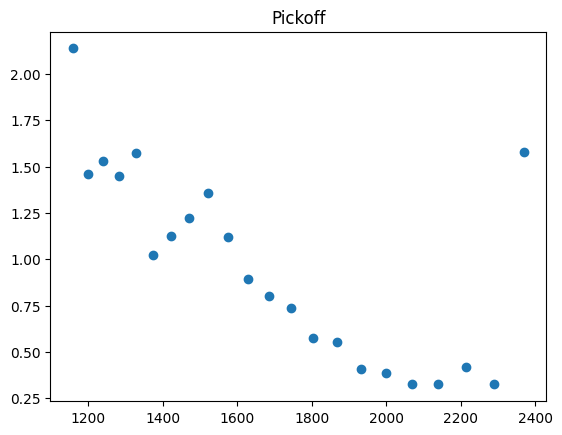

In [8]:
# plot s res without circular and 45 ret
plt.scatter(wavelength_bins, sres_list, marker='o')
plt.title('Pickoff')

Text(0.5, 1.0, 'No Pickoff')

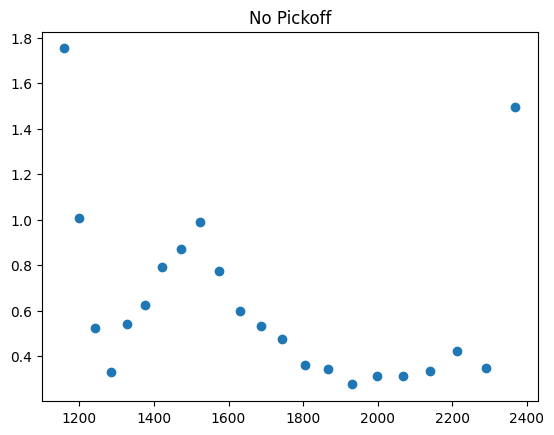

In [11]:
# plot s res with both circular and 45 ret
plt.scatter(wavelength_bins, sres_list, marker='o')
plt.title('No Pickoff')

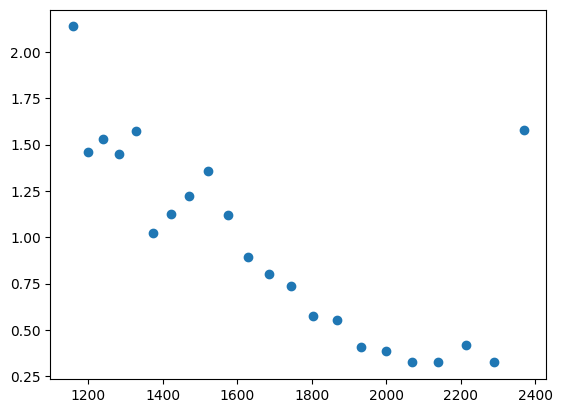

In [61]:
# plot s res with pickoff in data
plt.scatter(wavelength_bins, sres_list, marker='o')